# Modelo de previsão do Ibovespa

## 01 - Importação das bibliotecas

In [1]:
#Bibliotecas

from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error , r2_score, root_mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA
import warnings
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import periodogram
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit

warnings.filterwarnings("ignore")

c:\Users\pedro\Documents\Documentos\GitHub\techalleg_fase_2\.venv\Lib\site-packages\statsforecast\core.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
c:\Users\pedro\Documents\Documentos\GitHub\techalleg_fase_2\.venv\Lib\site-packages\statsforecast\utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


## 02 - Input dos dados

In [2]:
# Leitura do arquivo ** mostrar de onde veio o dado - 2005 até final de 2024

df = pd.read_csv('https://raw.githubusercontent.com/jdlmauricio/techalleg_fase_2/refs/heads/main/Dados%20Hist%C3%B3ricos%20-%20Ibovespa.csv')

## 03 - EDA (Exploratory Data Analysis)

In [3]:
# Visualizado dados ***

df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,30.12.2024,120.283,120.267,121.050,120.158,"8,90M","0,01%"
1,27.12.2024,120.269,121.078,121.609,120.252,"8,94M","-0,67%"
2,26.12.2024,121.078,120.767,121.612,120.428,"8,34M","0,26%"
3,23.12.2024,120.767,122.105,122.105,120.617,"9,95M","-1,09%"
4,20.12.2024,122.102,121.183,122.209,120.700,"18,13M","0,75%"


In [4]:
# Remove colunas desnecessárias ***
df = df.drop(columns=['Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'])
# Renomeia colunas
df = df.rename(columns={'Data': 'ds', 'Último': 'y'})
# Converte coluna de data
df['ds'] = pd.to_datetime(df['ds'], format='%d.%m.%Y')
# Colocando a data como index
df = df.set_index('ds')

In [5]:
df.head(15)

,y
ds,
2024-12-30,120.283
2024-12-27,120.269
2024-12-26,121.078
2024-12-23,120.767
2024-12-20,122.102
2024-12-19,121.188
2024-12-18,120.772
2024-12-17,124.698
2024-12-16,123.560


In [6]:
df.tail(15)

,y
ds,
2005-01-21,23.818
2005-01-20,23.610
2005-01-19,24.271
2005-01-18,24.089
2005-01-17,24.515
2005-01-14,24.924
2005-01-13,24.806
2005-01-12,24.510
2005-01-11,24.370


In [7]:
# Criando uma série completa com finais de semana e feriados ***
datas_completas = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reindex(datas_completas)

In [8]:
## Preenchendo valores ausentes com o último valor conhecido (forward-fill) ***
df['y'] = df['y'].fillna(method='ffill')

In [9]:
df.dtypes

y    float64
dtype: object

In [10]:
df.describe()

,y
count,7302.000000
mean,72.153192
std,29.048990
min,23.610000
25%,51.713750
50%,63.098000
75%,99.048750
max,137.344000


In [11]:
df.info

<bound method DataFrame.info of                   y
2005-01-03   25.722
2005-01-04   24.848
2005-01-05   24.692
2005-01-06   24.367
2005-01-07   24.747
...             ...
2024-12-26  121.078
2024-12-27  120.269
2024-12-28  120.269
2024-12-29  120.269
2024-12-30  120.283

[7302 rows x 1 columns]>

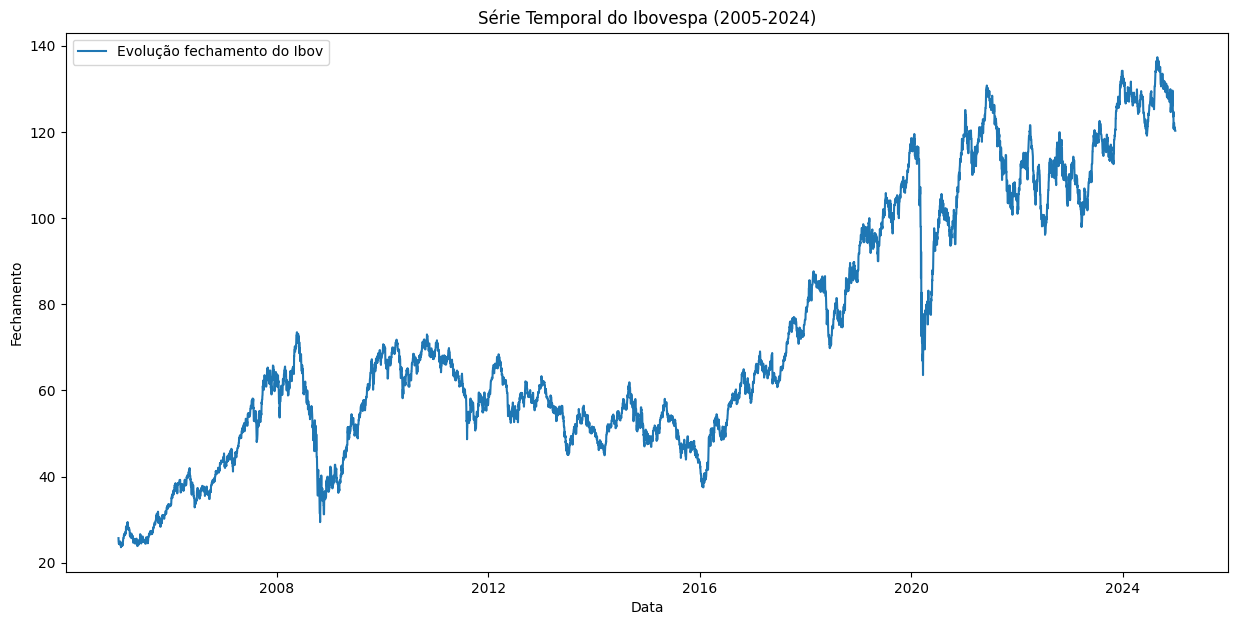

In [12]:
# plot da série temporal ***

plt.figure(figsize=(15, 7))
plt.plot(df.index, df['y'], label="Evolução fechamento do Ibov")
plt.title("Série Temporal do Ibovespa (2005-2024)")
plt.xlabel("Data")
plt.ylabel("Fechamento")
plt.legend()
plt.show()

### 3.1 Decomposição da série Temporal

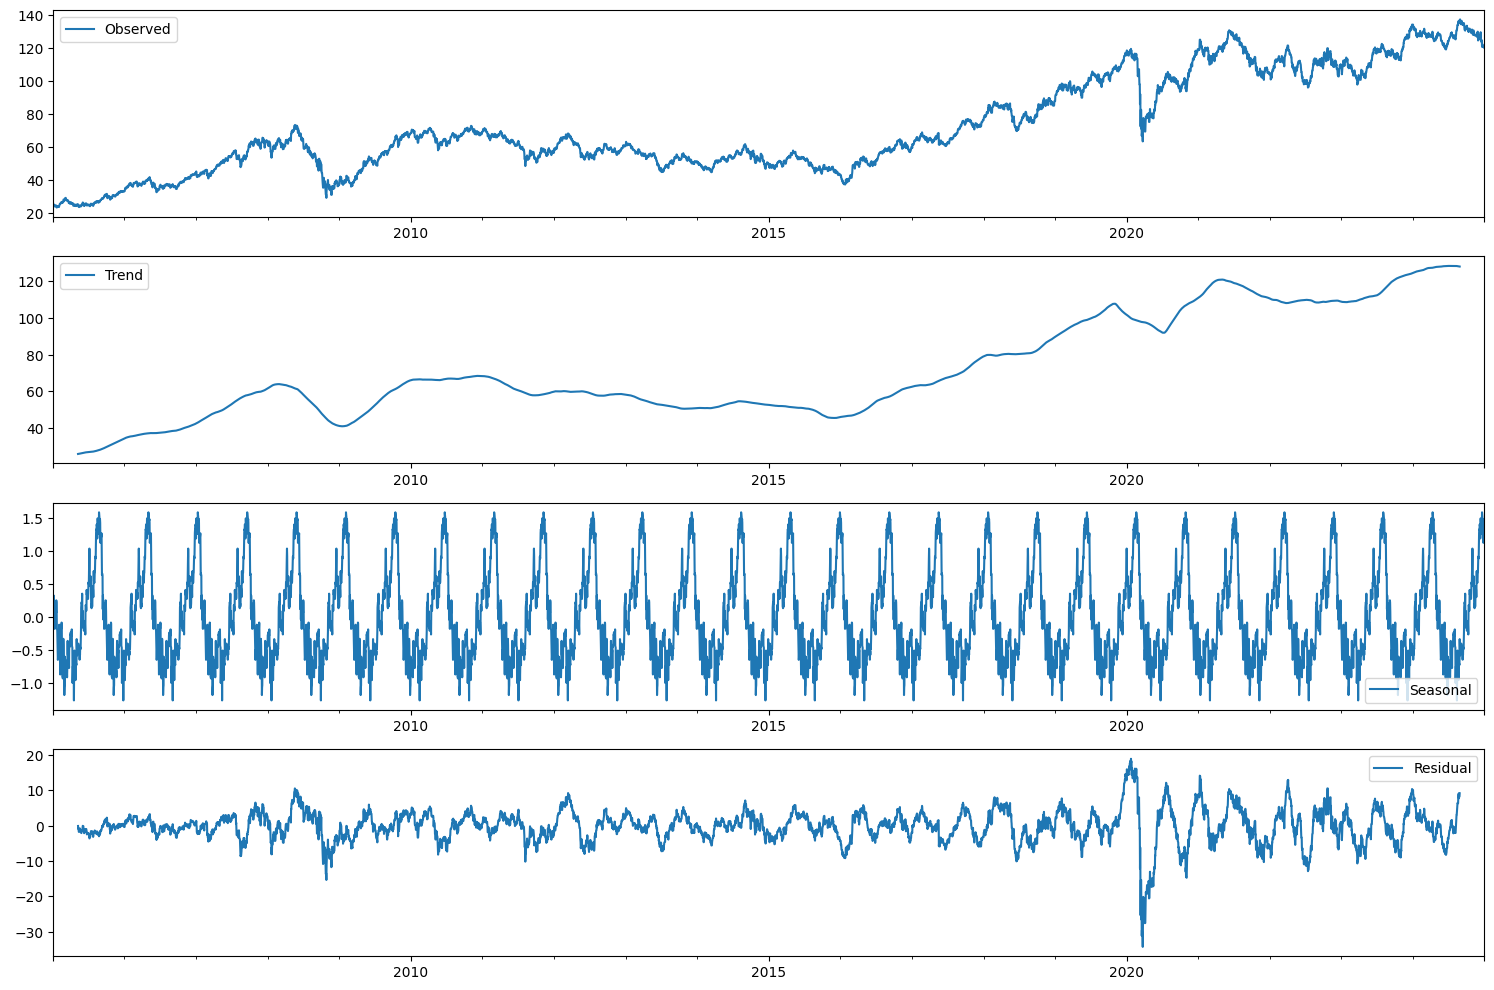

In [13]:
# Analisando a decomposição da série temporal (Método: decomposição aditiva) ***

detalhamento = seasonal_decompose(df["y"], model="additive", period=252)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

# Plotando a decomposição

detalhamento.observed.plot(ax=ax1, label='Observed')
detalhamento.trend.plot(ax=ax2, label='Trend')
detalhamento.seasonal.plot(ax=ax3, label='Seasonal')
detalhamento.resid.plot(ax=ax4, label='Residual')

# Adicionando as legendas
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.tight_layout()
plt.show()

## 04 - Modelos

### 4.1 Separação de base de treino e validação

In [14]:
# Definindo WMAPE (não existe na biblioteca do sklearn)

def wmape(y_true, y_pred):
  return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

In [15]:
df = df.reset_index()
df
df['unique_id'] = 0

In [16]:
df.rename(columns={'index': 'ds'}, inplace=True)

In [17]:
df.head()

,ds,y,unique_id
0,2005-01-03,25.722,0
1,2005-01-04,24.848,0
2,2005-01-05,24.692,0
3,2005-01-06,24.367,0
4,2005-01-07,24.747,0


In [18]:
df.dtypes

ds           datetime64[ns]
y                   float64
unique_id             int64
dtype: object

In [19]:
# Definição de período de Treino e validação ***

treino = df.loc[(df['ds'] >= '2022-01-01') & (df['ds'] < '2024-01-01')]

valid = df.loc[(df['ds'] >= '2024-01-01') & (df['ds'] < '2024-01-16')]

h = valid['ds'].nunique() # Quantidade de dias a serem previstos

In [20]:
h

15

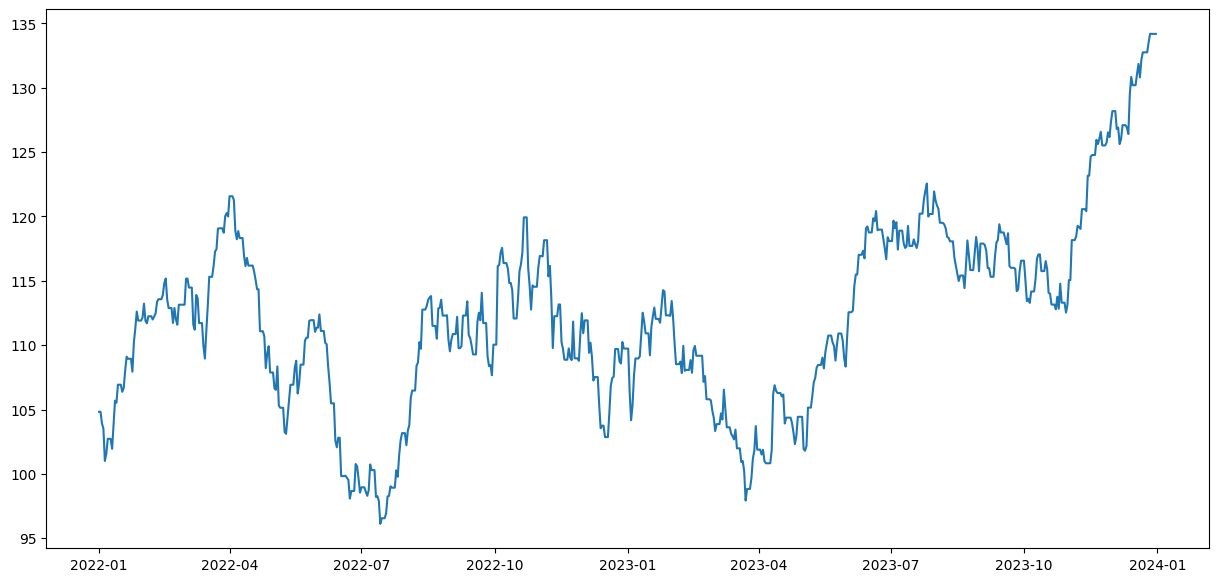

In [21]:
plt.figure(figsize=(15, 7))
plt.plot(treino['ds'], treino['y'], label='Treino')

In [22]:
treino.describe()

,ds,y,unique_id
count,730,730.000000,730.0
mean,2022-12-31 12:00:00,112.014901,0.0
min,2022-01-01 00:00:00,96.121000,0.0
25%,2022-07-02 06:00:00,107.436750,0.0
50%,2022-12-31 12:00:00,111.942000,0.0
75%,2023-07-01 18:00:00,116.652000,0.0
max,2023-12-31 00:00:00,134.194000,0.0
std,NaN,7.314243,0.0


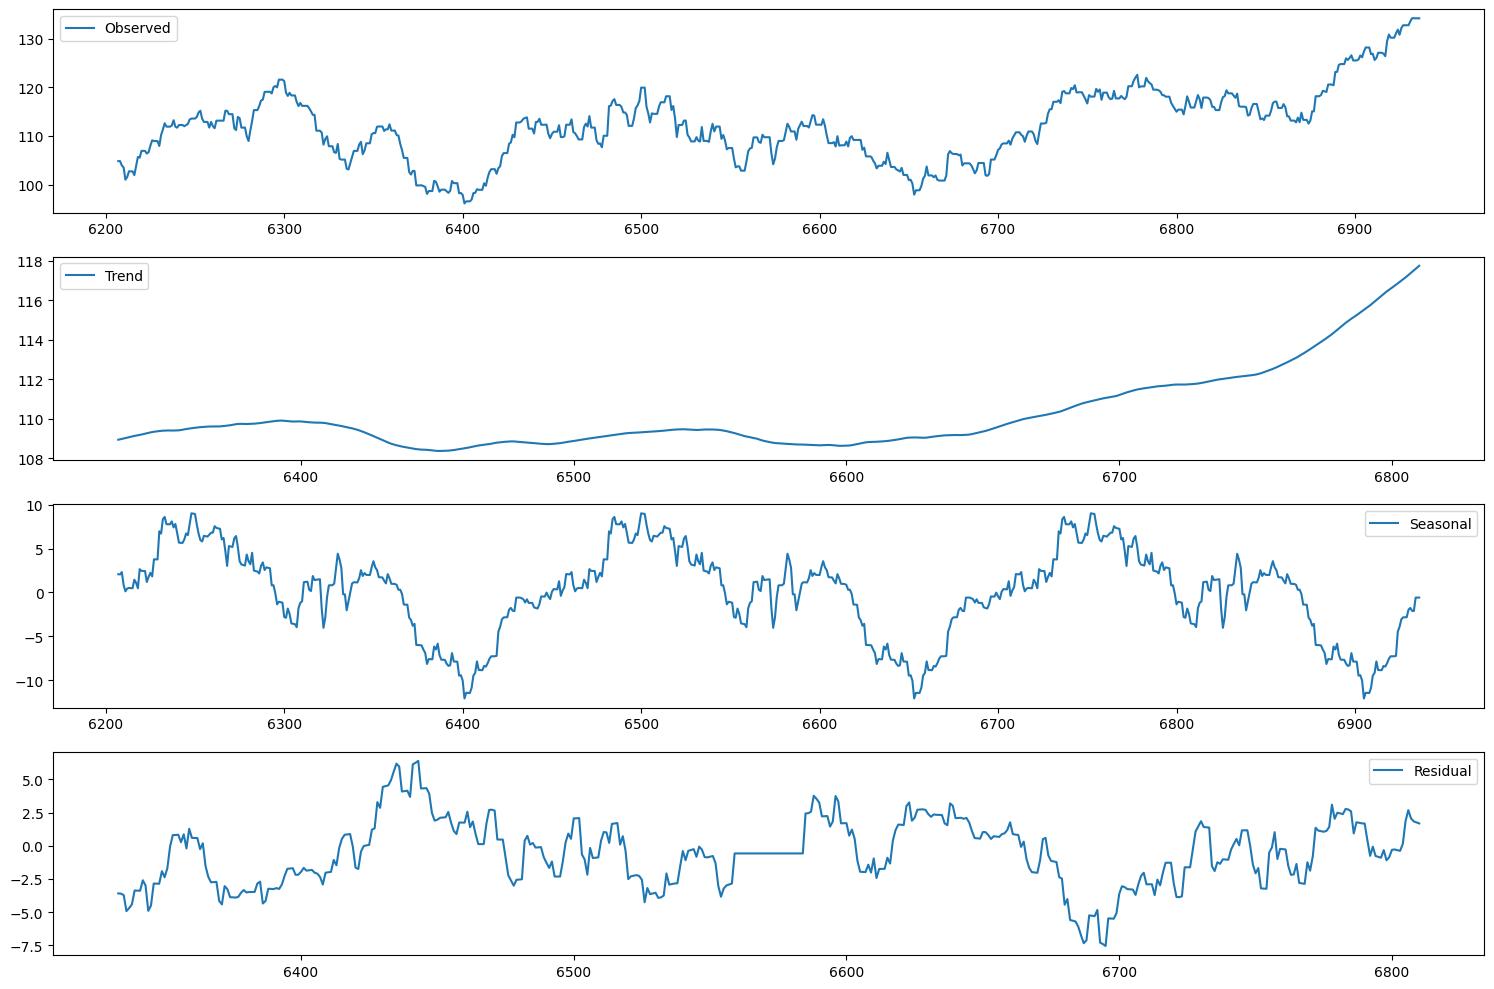

In [23]:
# Analisando a decomposição da série temporal (Método: decomposição aditiva)

detalhamento1 = seasonal_decompose(treino["y"], model="additive", period=252)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

# Plotando a decomposição

detalhamento1.observed.plot(ax=ax1, label='Observed')
detalhamento1.trend.plot(ax=ax2, label='Trend')
detalhamento1.seasonal.plot(ax=ax3, label='Seasonal')
detalhamento1.resid.plot(ax=ax4, label='Residual')

# Adicionando as legendas
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.tight_layout()
plt.show()

In [24]:
# Número de dias a serem previstos

h

15

### 4.2 - Naive - Baseline

In [25]:
#Escolha do modelo, períodocidade dos dados e número de processadores

naive_model = StatsForecast(models=[Naive()], freq='D', n_jobs=-1) # n_jobs é uma vairavel que determinando o número de processadores que serão utilizados, o -1 é para utilizar todos os processadores

#Treinando o modelo

naive_model.fit(treino)

# definindo o período de previsão e o intervalo de confiança

forecast_naive = naive_model.predict(h=h, level=[90]) # level identifica o intervalo de confiança, ou sej o nível de probabilidade de acerto

In [26]:
# Unindo o dataset de previsão com o dataset de validação

forecast_naive = forecast_naive.reset_index().merge(valid, on=['ds','unique_id'], how='left')

In [27]:
forecast_naive

,unique_id,ds,Naive,Naive-lo-90,Naive-hi-90,y
0,0,2024-01-01,134.184998,132.362061,136.007935,134.185
1,0,2024-01-02,134.184998,131.606964,136.763031,132.697
2,0,2024-01-03,134.184998,131.027573,137.342422,132.834
3,0,2024-01-04,134.184998,130.539108,137.830887,131.226
4,0,2024-01-05,134.184998,130.108780,138.261215,132.023
5,0,2024-01-06,134.184998,129.719727,138.650269,132.023
6,0,2024-01-07,134.184998,129.361954,139.008041,132.023
7,0,2024-01-08,134.184998,129.028946,139.341049,132.427
8,0,2024-01-09,134.184998,128.716171,139.653824,131.447
9,0,2024-01-10,134.184998,128.420349,139.949646,130.841


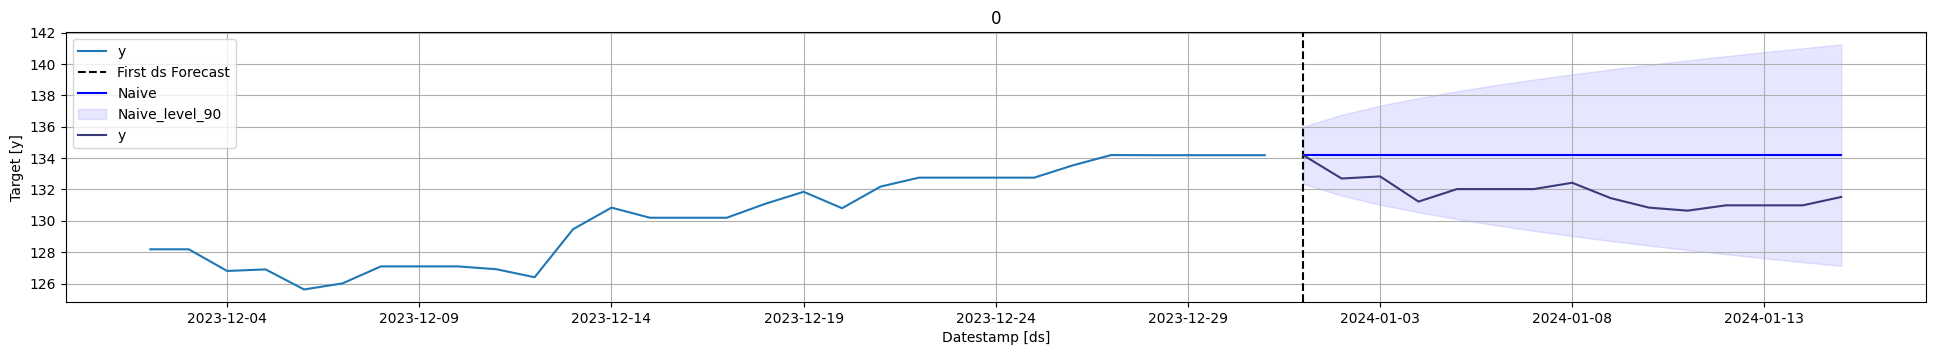

In [28]:
# Plotando o gráfico de previsão com histórico de 1 ano e previsão de 30 dias ***

naive_model.plot(treino, forecast_naive, level=[90],engine ='matplotlib', max_insample_length=30)

In [29]:
# Avaliação do modelo *** Resultado com foco no resultado do print

mae_naive = mean_absolute_error(forecast_naive['y'], forecast_naive['Naive'])
print(f'MAE Naive Baseline: {mae_naive}')

rmse_naive = root_mean_squared_error(forecast_naive['y'], forecast_naive['Naive'])
print(f'MAPE Naive Baseline: {rmse_naive}')

mape_naive = mean_absolute_percentage_error(forecast_naive['y'], forecast_naive['Naive'])
print(f'MAPE Naive Baseline: {mape_naive}')

wmape_naive = wmape(forecast_naive['y'].values, forecast_naive['Naive'].values)
print(f'WMAPE Naive Baseline: {wmape_naive:.2%}')

mse_naive = mean_squared_error(forecast_naive['y'], forecast_naive['Naive'])
print(f'MSE Naive Baseline: {mse_naive}')

r2_naive = r2_score(forecast_naive['y'], forecast_naive['Naive'])
print(f'R² Naive Baseline: {r2_naive}')

MAE Naive Baseline: 2.394331217447918
MAPE Naive Baseline: 2.567096227697468
MAPE Naive Baseline: 0.018217591255696986
WMAPE Naive Baseline: 1.82%
MSE Naive Baseline: 6.589983042258569
R² Naive Baseline: -6.688136266574274


### 4.3 - Seasonal Naive

In [30]:
#Escolha do modelo, períodocidade dos dados e número de processadores

# Definido sazonalidade de 21 dias corridos

s_naive_model = StatsForecast(models=[SeasonalNaive(season_length=14)], freq='D', n_jobs=-1) # n_jobs é uma vairavel que determinando o número de processadores que serão utilizados, o -1 é para utilizar todos os processadores

#Treinando o modelo

s_naive_model.fit(treino)

# definindo o período de previsão e o intervalo de confiança

forecast_s_naive = s_naive_model.predict(h=h, level=[90]) # level identifica o intervalo de confiança, ou sej o nível de probabilidade de acerto

In [31]:
# Unindo o dataset de previsão com o dataset de validação

forecast_s_naive = forecast_s_naive.reset_index().merge(valid, on=['ds','unique_id'], how='left')

In [32]:
forecast_s_naive.head()

,unique_id,ds,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,y
0,0,2024-01-01,131.084000,121.187561,140.980438,134.185
1,0,2024-01-02,131.850998,121.954559,141.747437,132.697
2,0,2024-01-03,130.804001,120.907562,140.700439,132.834
3,0,2024-01-04,132.182007,122.285568,142.078445,131.226
4,0,2024-01-05,132.753006,122.856567,142.649445,132.023


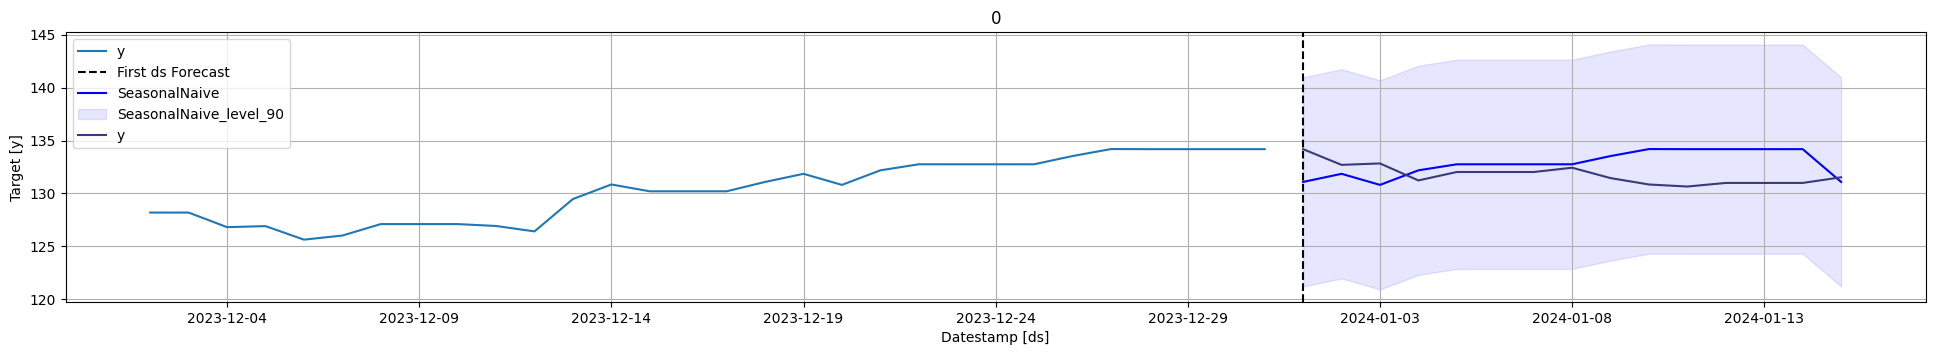

In [33]:
# Plotando o gráfico de previsão com histórico de 1 ano e previsão de 90 dias

s_naive_model.plot(treino, forecast_s_naive, level=[90],engine ='matplotlib', max_insample_length=30)

In [34]:
# Avaliação do modelo

mae_s_naive = mean_absolute_error(forecast_s_naive['y'], forecast_s_naive['SeasonalNaive'])
print(f'MAE SeasonalNaive Baseline: {mae_s_naive}')

rmse_s_naive = root_mean_squared_error(forecast_s_naive['y'], forecast_s_naive['SeasonalNaive'])
print(f'MAPE SeasonalNaive Baseline: {rmse_s_naive}')

mape_s_naive = mean_absolute_percentage_error(forecast_s_naive['y'], forecast_s_naive['SeasonalNaive'])
print(f'MAPE SeasonalNaive Baseline: {mape_s_naive}')

wmape_s_naive = wmape(forecast_s_naive['y'].values, forecast_s_naive['SeasonalNaive'].values)
print(f'WMAPE SeasonalNaive Baseline: {wmape_s_naive:.2%}')

mse_s_naive = mean_squared_error(forecast_s_naive['y'], forecast_s_naive['SeasonalNaive'])
print(f'MSE SeasonalNaive Baseline: {mse_s_naive}')

r2_s_naive = r2_score(forecast_s_naive['y'], forecast_s_naive['SeasonalNaive'])
print(f'R² SeasonalNaive Baseline: {r2_s_naive}')

MAE SeasonalNaive Baseline: 1.8968018636067712
MAPE SeasonalNaive Baseline: 2.2512578588399794
MAPE SeasonalNaive Baseline: 0.014413778814276268
WMAPE SeasonalNaive Baseline: 1.44%
MSE SeasonalNaive Baseline: 5.068161946988769
R² SeasonalNaive Baseline: -4.9127192618938444


### 4.4 - Seasonal Window Average

In [35]:
#Escolha do modelo, períodocidade dos dados e número de processadores

# Definido média móvel de 2 dias e com sazonalidade de 21 dias

swa_model = StatsForecast(models=[SeasonalWindowAverage(season_length=14, window_size=3)], freq='D', n_jobs=-1) # n_jobs é uma vairavel que determinando o número de processadores que serão utilizados, o -1 é para utilizar todos os processadores

#Treinando o modelo

swa_model.fit(treino)

# definindo o período de previsão e o intervalo de confiança

forecast_swa = swa_model.predict(h=h, level=[90]) # level identifica o intervalo de confiança, ou sej o nível de probabilidade de acerto

In [36]:
# Unindo o dataset de previsão com o dataset de validação

forecast_swa = forecast_swa.reset_index().merge(valid, on=['ds','unique_id'], how='left')

In [37]:
forecast_swa.head()

,unique_id,ds,SeasWA,y
0,0,2024-01-01,127.947998,134.185
1,0,2024-01-02,128.126663,132.697
2,0,2024-01-03,127.487335,132.834
3,0,2024-01-04,128.255997,131.226
4,0,2024-01-05,128.454666,132.023


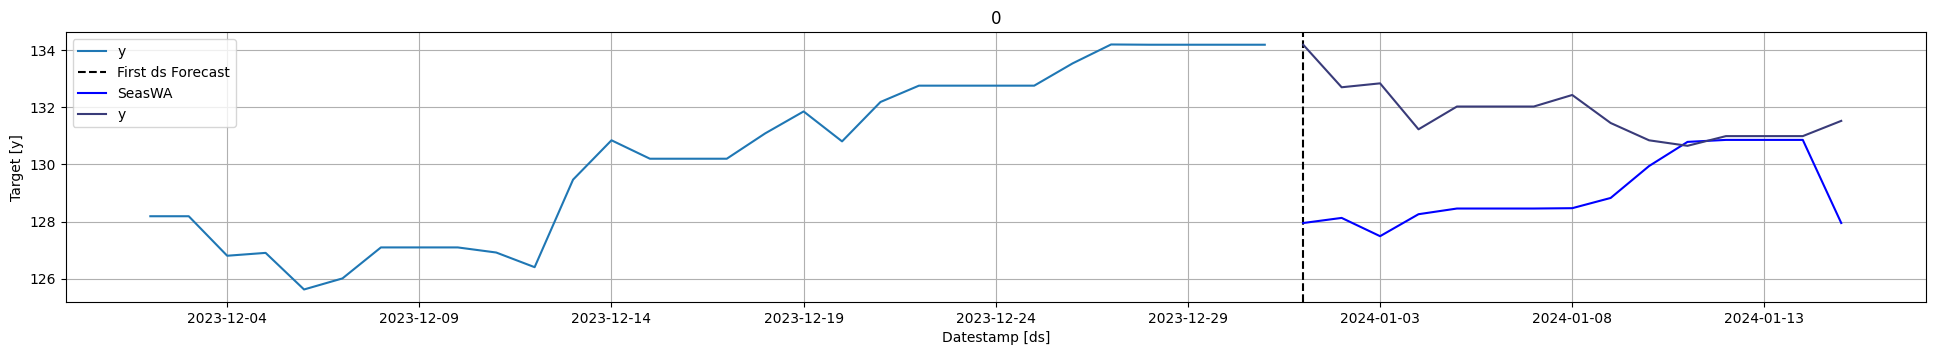

In [38]:
# Plotando o gráfico de previsão com histórico de 1 ano e previsão de 90 dias ***

swa_model.plot(treino, forecast_swa, level=[90],engine ='matplotlib', max_insample_length=30)

In [39]:
# Avaliação do modelo *** Resultado com foco no resultado do print

mae_swa = mean_absolute_error(forecast_swa['y'], forecast_swa['SeasWA'])
print(f'MAE swa : {mae_swa}')

rmse_swa = root_mean_squared_error(forecast_swa['y'], forecast_swa['SeasWA'])
print(f'MAPE swa : {rmse_swa}')

mape_swa = mean_absolute_percentage_error(forecast_swa['y'], forecast_swa['SeasWA'])
print(f'MAPE swa : {mape_swa}')

wmape_swa = wmape(forecast_swa['y'].values, forecast_swa['SeasWA'].values)
print(f'WMAPE swa : {wmape_swa:.2%}')

mse_swa = mean_squared_error(forecast_swa['y'], forecast_swa['SeasWA'])
print(f'MSE swa : {mse_swa}')

r2_swa = r2_score(forecast_swa['y'], forecast_swa['SeasWA'])
print(f'R² swa : {r2_swa}')

MAE swa : 2.761199169921874
MAPE swa : 3.3823280001818268
MAPE swa : 0.020857692203904342
WMAPE swa : 2.10%
MSE swa : 11.440142700813995
R² swa : -12.346525389960485


### 4.5 - Auto-ARIMA (edição - resultados merda)

In [40]:
#Escolha do modelo, períodocidade dos dados e número de processadores

# Definido média móvel de 21 dias corridos e com sazonalidade trimestral

a_arima_model = StatsForecast(models=[AutoARIMA(season_length=730)], freq='D', n_jobs=-1) # n_jobs é uma vairavel que determinando o número de processadores que serão utilizados, o -1 é para utilizar todos os processadores

#Treinando o modelo

a_arima_model.fit(treino)

# definindo o período de previsão e o intervalo de confiança

forecast_a_arima = a_arima_model.predict(h=h, level=[90]) # level identifica o intervalo de confiança, ou sej o nível de probabilidade de acerto

In [41]:
# Unindo o dataset de previsão com o dataset de validação

forecast_a_arima = forecast_a_arima.reset_index().merge(valid, on=['ds','unique_id'], how='left')

In [42]:
forecast_a_arima.head()

,unique_id,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,y
0,0,2024-01-01,134.184998,132.360794,136.009201,134.185
1,0,2024-01-02,134.184998,131.605179,136.764816,132.697
2,0,2024-01-03,134.184998,131.025391,137.344604,132.834
3,0,2024-01-04,134.184998,130.536591,137.833405,131.226
4,0,2024-01-05,134.184998,130.105957,138.264038,132.023


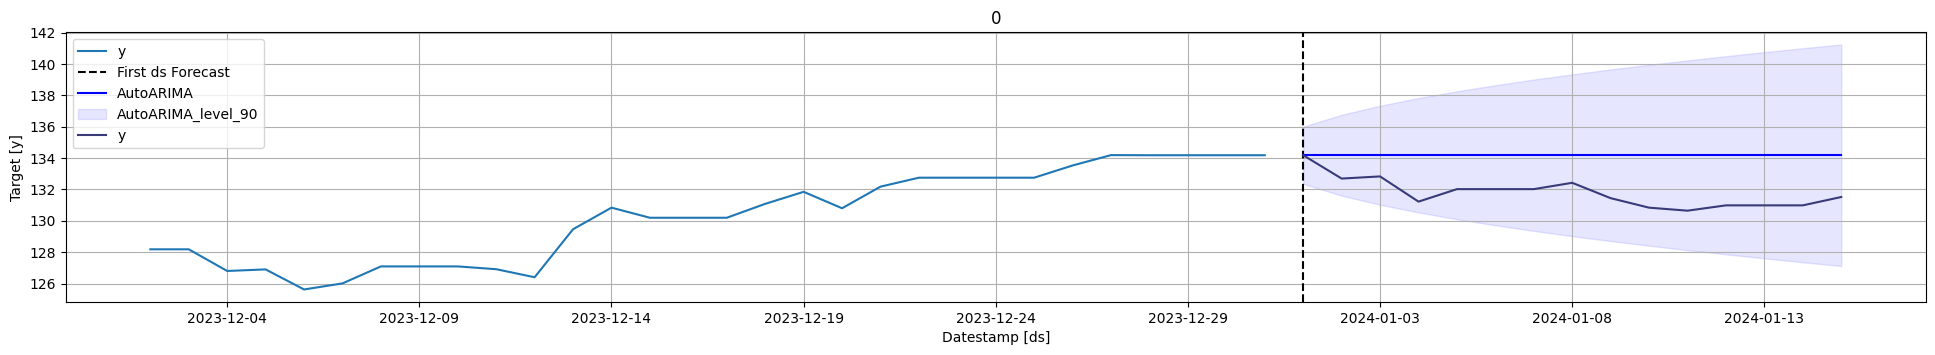

In [43]:
# Plotando o gráfico de previsão com histórico de 1 ano e previsão de 90 dias

a_arima_model.plot(treino, forecast_a_arima, level=[90],engine ='matplotlib', max_insample_length=30)

In [44]:
# Avaliação do modelo

mae_a_arima = mean_absolute_error(forecast_a_arima['y'], forecast_a_arima['AutoARIMA'])
print(f'MAE a_arima : {mae_a_arima}')

rmse_a_arima = root_mean_squared_error(forecast_a_arima['y'], forecast_a_arima['AutoARIMA'])
print(f'MAPE a_arima : {rmse_a_arima}')

mape_a_arima = mean_absolute_percentage_error(forecast_a_arima['y'], forecast_a_arima['AutoARIMA'])
print(f'MAPE a_arima : {mape_a_arima}')

wmape_a_arima = wmape(forecast_a_arima['y'].values, forecast_a_arima['AutoARIMA'].values)
print(f'WMAPE a_arima : {wmape_a_arima:.2%}')

mse_a_arima = mean_squared_error(forecast_a_arima['y'], forecast_a_arima['AutoARIMA'])
print(f'MSE a_arima : {mse_a_arima}')

r2_a_arima = r2_score(forecast_a_arima['y'], forecast_a_arima['AutoARIMA'])
print(f'R² a_arima : {r2_a_arima}')

MAE a_arima : 2.394331217447918
MAPE a_arima : 2.567096227697468
MAPE a_arima : 0.018217591255696986
WMAPE a_arima : 1.82%
MSE a_arima : 6.589983042258569
R² a_arima : -6.688136266574274


### 4.6 - Modelos Arima e Sarima

#### 4.6.1 - Feature Engineering

##### 4.6.1.1 - Estacionarização da série

In [45]:
df_arima_valid = valid.copy()

In [46]:
# Remove colunas desnecessárias
df_arima_valid = df_arima_valid.drop(columns=['unique_id'])
# Colocando a data como index
df_arima_valid = df_arima_valid.set_index('ds')

In [47]:
df_arima_valid

,y
ds,
2024-01-01,134.185
2024-01-02,132.697
2024-01-03,132.834
2024-01-04,131.226
2024-01-05,132.023
2024-01-06,132.023
2024-01-07,132.023
2024-01-08,132.427
2024-01-09,131.447


In [48]:
df_arima = treino.copy()

In [49]:
# Remove colunas desnecessárias
df_arima = df_arima.drop(columns=['unique_id'])
# Colocando a data como index
df_arima = df_arima.set_index('ds')

In [50]:
df_arima.head()

,y
ds,
2022-01-01,104.822
2022-01-02,104.822
2022-01-03,103.922
2022-01-04,103.514
2022-01-05,101.006


In [51]:
df_arima.dtypes

y    float64
dtype: object

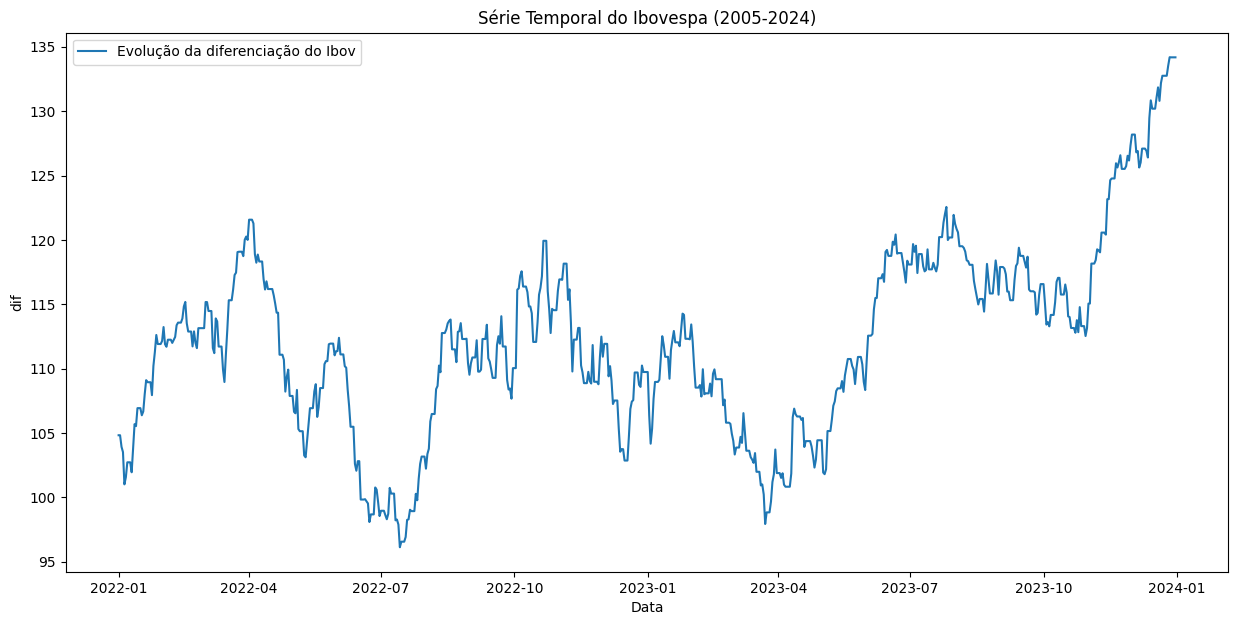

In [52]:
# Plot do dado: ***

plt.figure(figsize=(15, 7))
plt.plot(df_arima.index, df_arima["y"], label="Evolução da diferenciação do Ibov")
plt.title("Série Temporal do Ibovespa (2005-2024)")
plt.xlabel("Data")
plt.ylabel("dif")
plt.legend()
plt.show()

In [53]:
# Testando a Estacionariedade ***
    # Teste de Dickey-fuller Aumentado (ADF)

# Teste ADF
resultado_adf = adfuller(df_arima["y"].dropna())
print(f"Estatística ADF: {resultado_adf[0]}")
print(f"Valor-p: {resultado_adf[1]:.15e}")
for key, value in resultado_adf[4].items():
    print(f"Valor Crítico {key}: {value}")

# Interpretação
if resultado_adf[1] < 0.05:
    print("A série é estacionária.")
else:
    print("A série não é estacionária.")

Estatística ADF: -1.0434428618926104
Valor-p: 7.370917469076536e-01
Valor Crítico 1%: -3.4393520240470554
Valor Crítico 5%: -2.8655128165959236
Valor Crítico 10%: -2.5688855736949163
A série não é estacionária.


Método da Diferenciação de primeira Ordem

In [54]:
# Estacionarização da Série (Método: Diferenciação) ***

# Criando coluna com diferenciação do dado corrente e dado shiftado
df_arima['dif'] = df_arima['y'] - df_arima['y'].shift(1)
df_arima = df_arima.dropna()  # Remova os valores NaN gerados pela diferenciação

In [55]:
df_arima.head()

,y,dif
ds,,
2022-01-02,104.822,0.000
2022-01-03,103.922,-0.900
2022-01-04,103.514,-0.408
2022-01-05,101.006,-2.508
2022-01-06,101.561,0.555


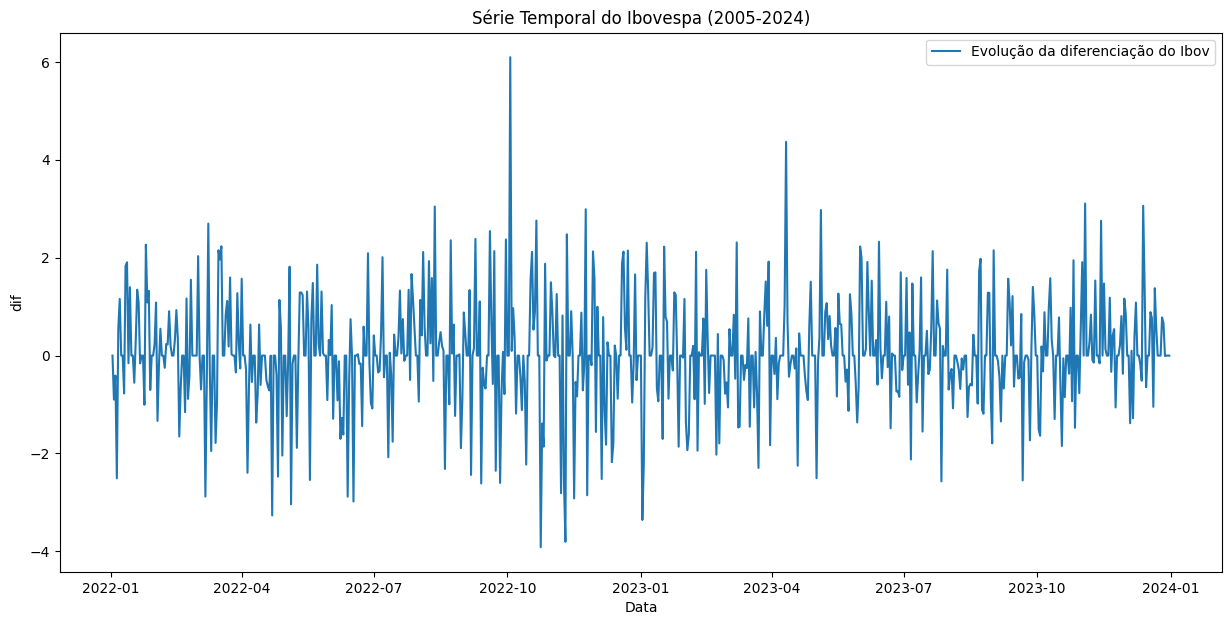

In [56]:
# Plot do dado Diferenciado: ***

plt.figure(figsize=(15, 7))
plt.plot(df_arima.index, df_arima["dif"], label="Evolução da diferenciação do Ibov")
plt.title("Série Temporal do Ibovespa (2005-2024)")
plt.xlabel("Data")
plt.ylabel("dif")
plt.legend()
plt.show()

In [57]:
# Testando a Estacionariedade ***
    # Teste de Dickey-fuller Aumentado (ADF)

# Teste ADF
resultado_adf_dif = adfuller(df_arima["dif"].dropna())
print(f"Estatística ADF: {resultado_adf_dif[0]}")
print(f"Valor-p: {resultado_adf_dif[1]:.15e}")
for key, value in resultado_adf_dif[4].items():
    print(f"Valor Crítico {key}: {value}")

# Interpretação
if resultado_adf_dif[1] < 0.05:
    print("A série é estacionária.")
else:
    print("A série não é estacionária.")

Estatística ADF: -26.351190349090174
Valor-p: 0.000000000000000e+00
Valor Crítico 1%: -3.4393644334758475
Valor Crítico 5%: -2.8655182850048306
Valor Crítico 10%: -2.568888486973192
A série é estacionária.


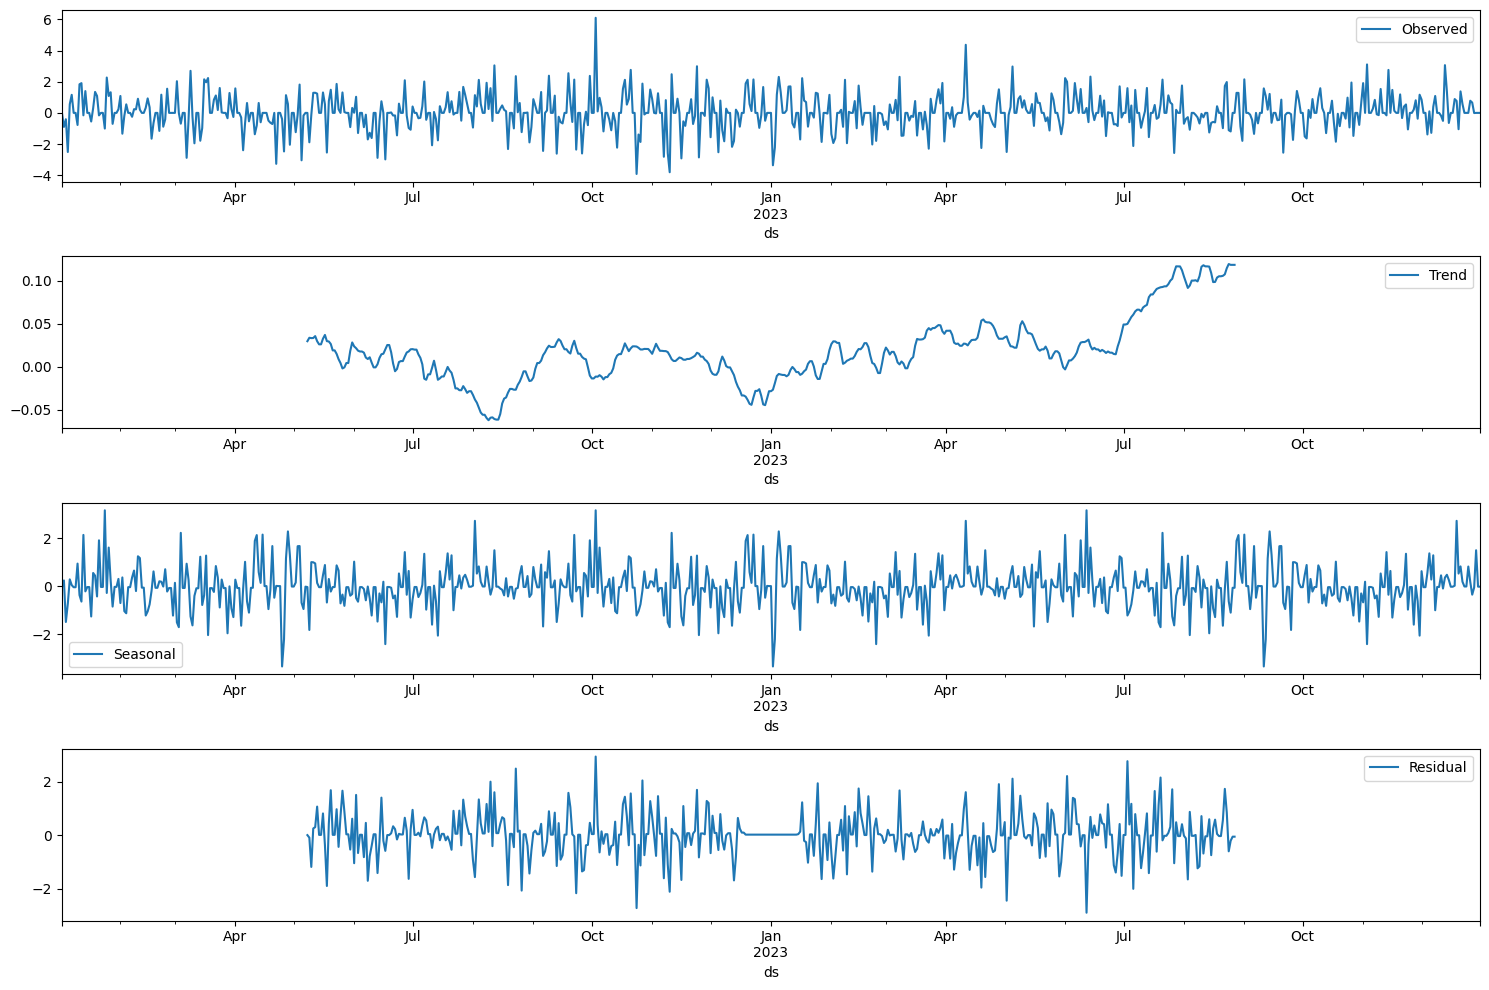

In [58]:
# Analisando a decomposição da série temporal (Método: decomposição aditiva)

detalhamento2 = seasonal_decompose(df_arima["dif"], model="additive", period=252)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

# Plotando a decomposição

detalhamento2.observed.plot(ax=ax1, label='Observed')
detalhamento2.trend.plot(ax=ax2, label='Trend')
detalhamento2.seasonal.plot(ax=ax3, label='Seasonal')
detalhamento2.resid.plot(ax=ax4, label='Residual')

# Adicionando as legendas
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.tight_layout()
plt.show()

##### 4.6.1.2 - Identificação dos parâmetros para o modelo

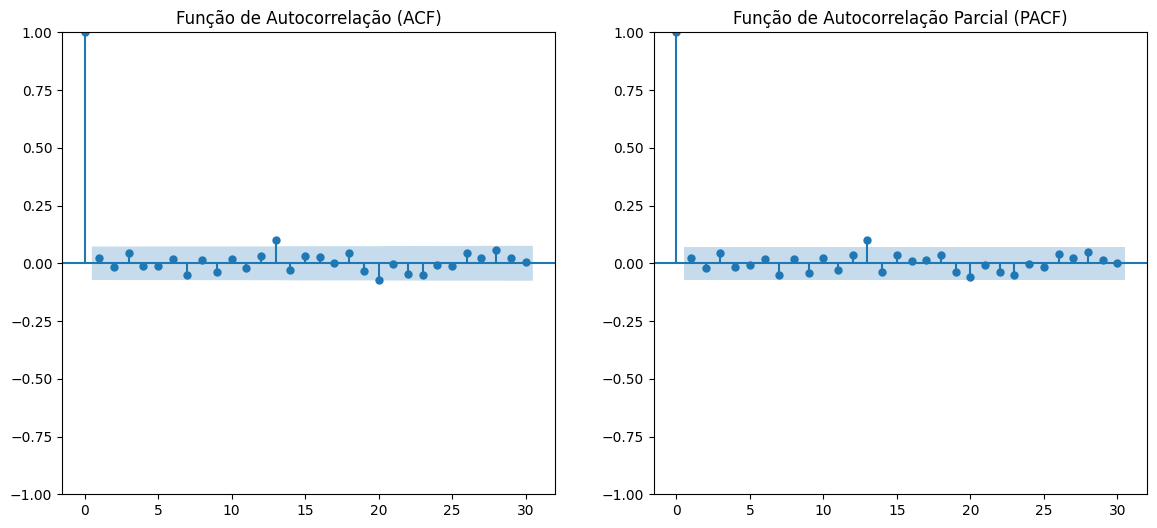

In [59]:
# Identificação dos Parâmetros do Modelo ARIMA - PACF - AR (AutoRegressivo): p, I (Integrado): d, ACF - MA (Média Móvel): q ***

# Plot da ACF e PACF da série diferenciada

plt.figure(figsize=(14, 6))

#Plot ACF: q
plt.subplot(121)
plot_acf(df_arima["dif"].dropna(), ax=plt.gca(), lags=30)
plt.title("Função de Autocorrelação (ACF)")

#Plot PACF: p
plt.subplot(122)
plot_pacf(df_arima["dif"].dropna(), ax=plt.gca(), lags=30)
plt.title("Função de Autocorrelação Parcial (PACF)")
plt.show()

In [60]:
p = 1 # compentente AR ***
d = 1 # Componente I
q = 1 # Componente MA

#### 4.6.2 - Previsão do modelo Arima

In [61]:
# Ajuste do modelo ARIMA(p, d, q)

# Suposição: p=2, d=1, q=2 (com base na análise dos gráficos ACF e PACF)

model_arima = ARIMA(df_arima["dif"], order=(p, d, q))
resultado_arima = model_arima.fit()

# Resumo do modelo
print(resultado_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                    dif   No. Observations:                  729
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1110.937
Date:                Sun, 19 Jan 2025   AIC                           2227.874
Time:                        14:25:59   BIC                           2241.645
Sample:                    01-02-2022   HQIC                          2233.188
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0236      0.038      0.625      0.532      -0.050       0.098
ma.L1         -0.9998      0.123     -8.113      0.000      -1.241      -0.758
sigma2         1.2280      0.154      7.987      0.0

In [62]:
# Previsão dos próximos 91 dias
forecast_arima = resultado_arima.forecast(steps=15)

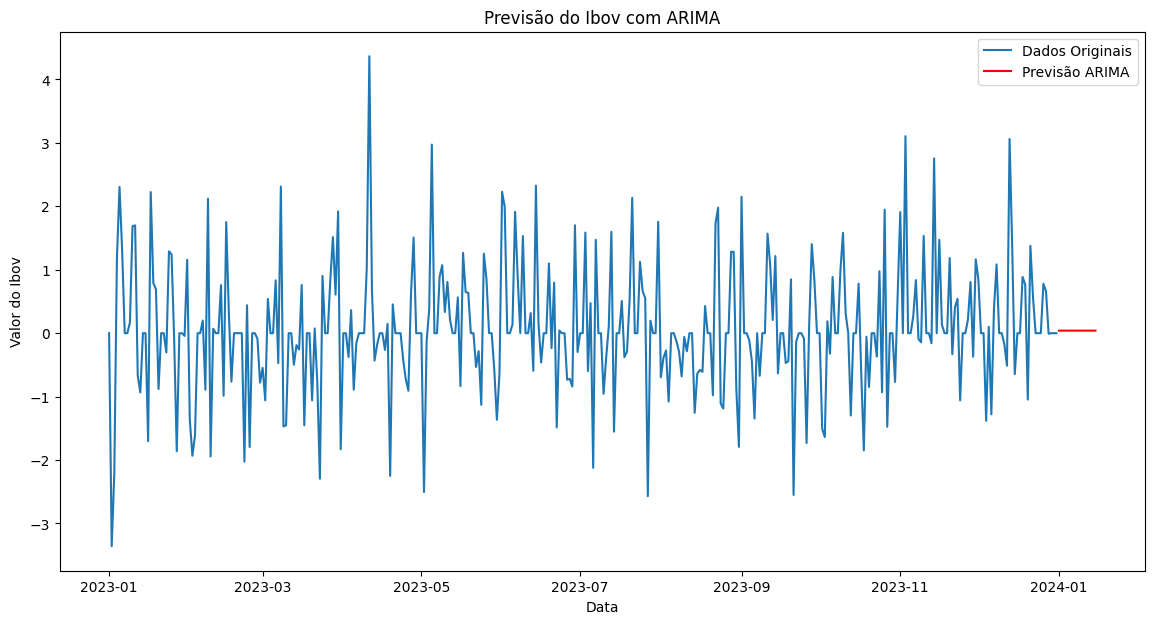

In [63]:
# Plot das previsões
plt.figure(figsize=(14, 7))
plt.plot(df_arima["dif"].iloc[-365:], label="Dados Originais")
plt.plot(forecast_arima.index, forecast_arima, color="red", label="Previsão ARIMA")
plt.title("Previsão do Ibov com ARIMA")
plt.xlabel("Data")
plt.ylabel("Valor do Ibov")
plt.legend()
plt.show()

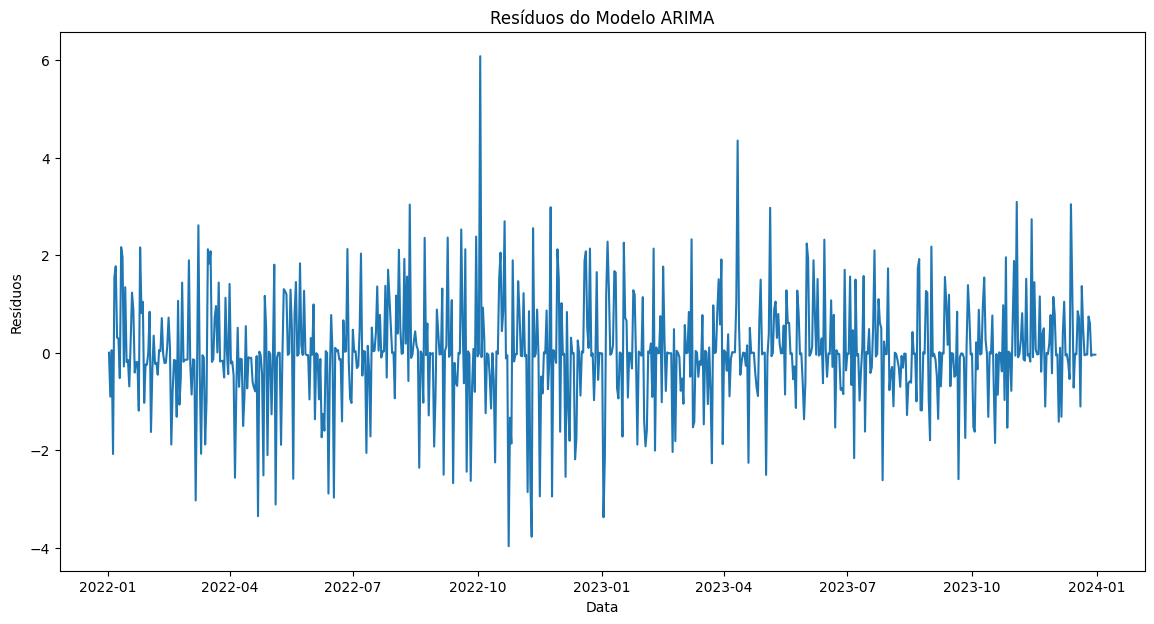

,lb_stat,lb_pvalue
10,5.616406,0.846396


In [64]:
# Resíduos do modelo ARIMA
resid_arima = resultado_arima.resid

# Plot dos resíduos
plt.figure(figsize=(14, 7))
plt.plot(resid_arima)
plt.title("Resíduos do Modelo ARIMA")
plt.xlabel("Data")
plt.ylabel("Resíduos")
plt.show()

# Teste de Ljung-Box
lb_test = acorr_ljungbox(resid_arima, lags=[10], return_df=True)
lb_test

In [65]:
# Avaliação do modelo

mae_arima = mean_absolute_error(df_arima_valid, forecast_arima)
print(f'MAE arima : {mae_arima}')

rmse_arima = root_mean_squared_error(df_arima_valid, forecast_arima)
print(f'MAPE arima : {rmse_arima}')

mape_arima = mean_absolute_percentage_error(df_arima_valid, forecast_arima)
print(f'MAPE arima : {mape_arima}')

mse_arima = mean_squared_error(df_arima_valid, forecast_arima)
print(f'MSE arima : {mse_arima}')

r2_arima = r2_score(df_arima_valid, forecast_arima)
print(f'R² arima : {r2_arima}')

MAE arima : 131.7502747887753
MAPE arima : 131.75352889994065
MAPE arima : 0.9996934911269932
MSE arima : 17358.992377587496
R² arima : -20250.690784863833


#### 4.6.3 - Previsão do modelo Samira

In [66]:
s = 21 # assumindo sazonalidade de 21 dias **

model_sarima = SARIMAX(df_arima['dif'], 
                order=(1, 1, 1), # Parâmetros pelo ACF e PACF
                seasonal_order=(1, 1, 1, s)) # Parâmetros sazonais
resultado_sarima = model_sarima.fit(disp=False)


# Resumo do modelo
print(resultado_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                dif   No. Observations:                  729
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 21)   Log Likelihood               -1120.293
Date:                            Sun, 19 Jan 2025   AIC                           2250.587
Time:                                    14:26:05   BIC                           2273.392
Sample:                                01-02-2022   HQIC                          2259.398
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0267      0.037      0.729      0.466      -0.045       0.099
ma.L1         -0.9997      0.291   

In [67]:
# Modelo SARIMA com dados de treino
forecast_sarima_train = resultado_sarima.forecast(steps=15)

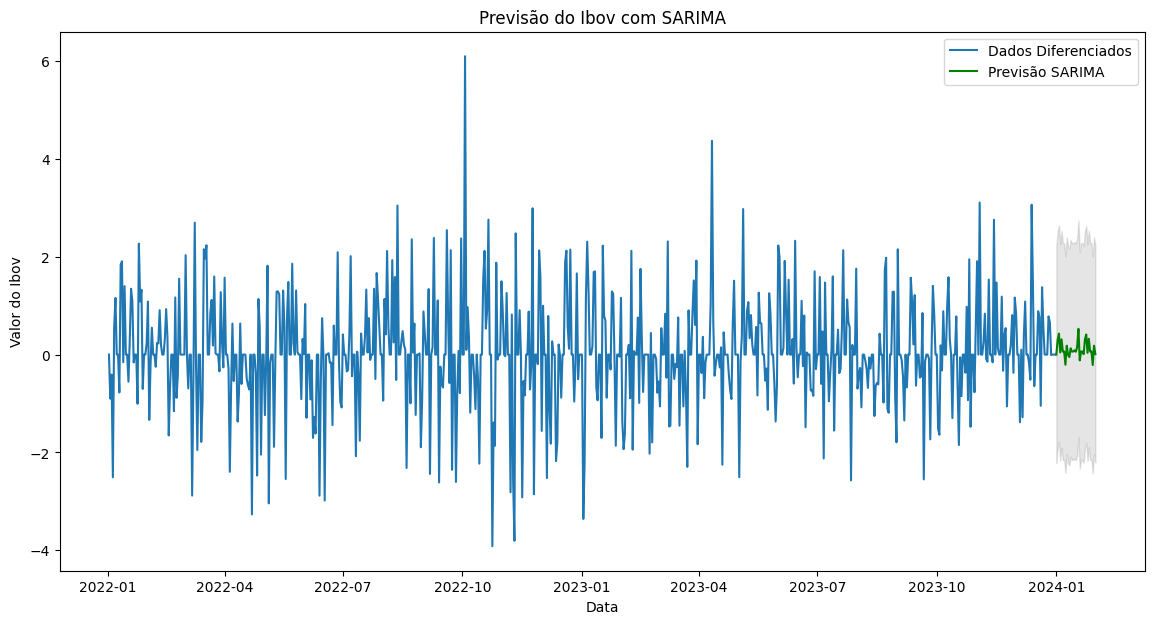

In [68]:
# # Previsão dos próximos 15 dias ***
forecast_sarima = resultado_sarima.get_forecast(steps=31)
forecast_sarima_mean = forecast_sarima.predicted_mean
forecast_sarima_conf_int = forecast_sarima.conf_int()

# Plot das previsões
plt.figure(figsize=(14, 7))
plt.plot(df_arima["dif"], label="Dados Diferenciados")
plt.plot(
    forecast_sarima_mean.index,
    forecast_sarima_mean,
    color="green",
    label="Previsão SARIMA",
)
plt.fill_between(
    forecast_sarima_conf_int.index,
    forecast_sarima_conf_int.iloc[:, 0],
    forecast_sarima_conf_int.iloc[:, 1],
    color="k",
    alpha=0.1,
)
plt.title("Previsão do Ibov com SARIMA")
plt.xlabel("Data")
plt.ylabel("Valor do Ibov")
plt.legend()
plt.show()

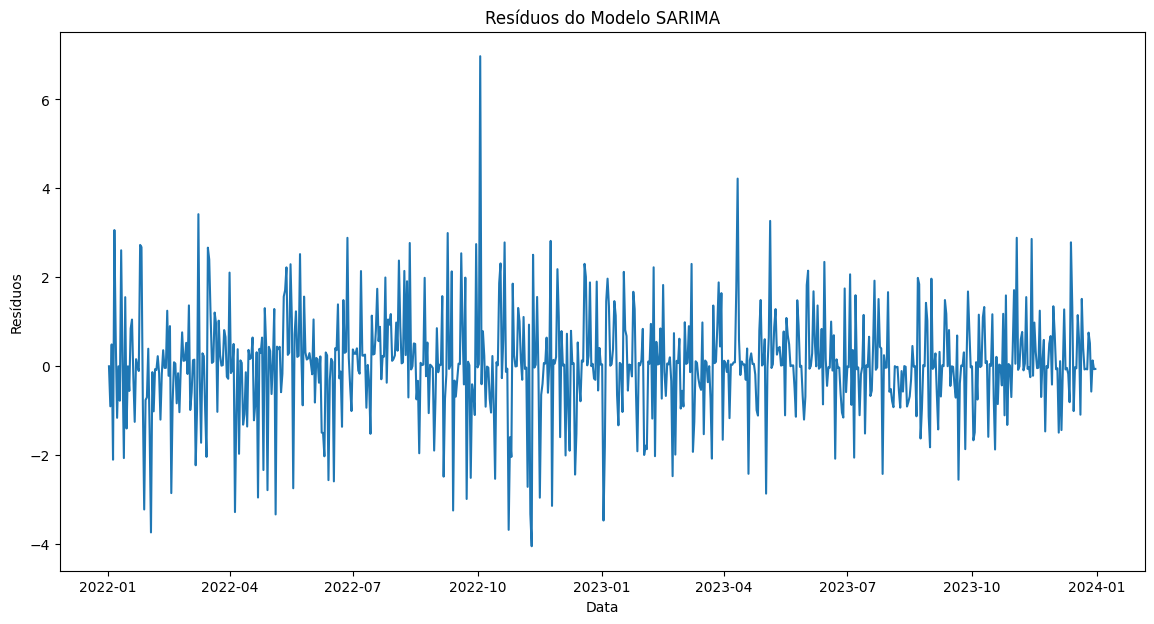

     lb_stat  lb_pvalue
10  5.685971   0.840921


In [69]:
# Resíduos do modelo SARIMA
resid_sarima = resultado_sarima.resid

# Plot dos resíduos
plt.figure(figsize=(14, 7))
plt.plot(resid_sarima)
plt.title("Resíduos do Modelo SARIMA")
plt.xlabel("Data")
plt.ylabel("Resíduos")
plt.show()

# Teste de Ljung-Box
lb_test_sarima = acorr_ljungbox(resid_sarima, lags=[10], return_df=True)
print(lb_test_sarima)

In [70]:
# Avaliação do modelo *** Resultado com foco no resultado do print

mae_sarima = mean_absolute_error(df_arima_valid, forecast_sarima_train)
print(f'MAE sarima : {mae_sarima}')

rmse_sarima = root_mean_squared_error(df_arima_valid, forecast_sarima_train)
print(f'MAPE sarima : {rmse_sarima}')

mape_sarima = mean_absolute_percentage_error(df_arima_valid, forecast_sarima_train)
print(f'MAPE sarima : {mape_sarima}')

mse_sarima = mean_squared_error(df_arima_valid, forecast_sarima_train)
print(f'MSE sarima : {mse_sarima}')

r2_sarima = r2_score(df_arima_valid, forecast_sarima_train)
print(f'R² sarima : {r2_sarima}')

MAE sarima : 131.69298762662234
MAPE sarima : 131.69610930576354
MAPE sarima : 0.9992604788380022
MSE sarima : 17343.86520627562
R² sarima : -20233.042825282188


### 4.7 - Modelos Avançados (LSTM,Xboost,prophet)

### 4.7.1 - LSTM

#### 4.7.1.1 Feature Engineering

In [71]:
# Preparando Dataset

treino_lstm = treino.drop(columns=['unique_id'])
valid_lstm = valid.drop(columns=['unique_id'])

In [72]:
# Processo de normalização dos dados:

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(treino_lstm[['y']])
test_scaled = scaler.transform(valid_lstm[['y']])

In [73]:
# ETL para LSTM

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 21
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

#### 4.7.1.2 Previsão do Modelo LSTM

In [74]:
# Construção do modelo LSTM

lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')

In [75]:
# Treinamento do Modelo

lstm.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1376
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0097
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0050
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0041
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025
Epoch 10/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027


In [76]:
# Precisão com o modelo

lstm_pred = lstm.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred)

ValueError: math domain error

In [ ]:
# Erro do modelo

mse_lstm = mean_squared_error(y_test, lstm_pred)
print(f'LSTM MSE: {mse_lstm}')

### 4.8.1 - XGboost Regressor

In [ ]:
df.head()

In [195]:
df_Xboost = df.copy()

In [196]:
df_Xboost = df_Xboost.drop(columns=['unique_id'])

In [80]:
df_Xboost = df_Xboost.set_index('ds')

In [ ]:
df_Xboost.head()

In [82]:
# Adicionar as features temporais

df_Xboost['day'] = df_Xboost.index.day
df_Xboost['week_of_year'] = df_Xboost.index.isocalendar().week
df_Xboost['month'] = df_Xboost.index.month
df_Xboost['year'] = df_Xboost.index.year

In [83]:
# Estacionarização da Série (Método: Diferenciação)

# Criando coluna com diferenciação do dado corrente e dado shiftado
df_Xboost['dif'] = df_Xboost['y'] - df_Xboost['y'].shift(1)
df_Xboost = df_Xboost.dropna()  # Remova os valores NaN gerados pela diferenciação

In [ ]:
# Plot da ACF e PACF da série diferenciada

plt.figure(figsize=(20, 10))
plot_acf(df_Xboost["dif"].dropna(), ax=plt.gca(), lags=30)
plt.title("Função de Autocorrelação (ACF)")

In [85]:
n_lags = 2
for lag in range(1, n_lags + 1):
    df_Xboost[f'lag_{lag}'] = df_Xboost['dif'].shift(lag)

In [86]:
# Criando variáveis dummies para os meses

# Rolling statistics
df_Xboost[f'rolling_mean_{n_lags}'] = df_Xboost['dif'].rolling(window=n_lags).mean()
df_Xboost[f'rolling_std_{n_lags}'] = df_Xboost['dif'].rolling(window=n_lags).std()

# Exponential Moving Averages (EMA)
df_Xboost[f'ema_{n_lags}'] = df_Xboost['dif'].ewm(span=n_lags).mean()
df_Xboost[f'ema_std_{n_lags}'] = df_Xboost['dif'].ewm(span=n_lags).std()

In [ ]:
# Criando termos de Fourier para sazonalidade

frequency, power = periodogram(df_Xboost['dif'].dropna(), fs=1)
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(frequency[1:], power[1:])
ax.set_title('Power Spectrum')
ax.set_xlabel('Frequency')
ax.set_ylabel('Power')
ax.set_yscale('log')
ax.get_figure().set_tight_layout(True)

freq = frequency[np.argmax(power)]
period = 1 / freq

print(f'Period: {period} days')

df_Xboost['fourier_sin'] = np.sin(2 * np.pi * freq * np.arange(len(df_Xboost)))
df_Xboost['fourier_cos'] = np.cos(2 * np.pi * freq * np.arange(len(df_Xboost)))

In [ ]:
df_Xboost[['fourier_sin', 'fourier_cos']].plot(subplots=True)

In [ ]:
stl = seasonal_decompose(df_Xboost['dif'].dropna(), period=365)
df_Xboost['trend'] = stl.trend
df_Xboost['seasonal'] = stl.seasonal
df_Xboost['residual'] = stl.resid

df_Xboost[['dif', 'trend', 'seasonal', 'residual']].plot(subplots=True)

In [90]:
# definindo o período de treino e validção

train_end = '2024-01-01'
df_train = df_Xboost.loc[:train_end]
df_test = df_Xboost.loc[train_end:]

In [91]:
predictors = [
    'day',
    'week_of_year',
    'month',
    'year',
    *['lag_{}'.format(i) for i in range(1, n_lags + 1)],
    'rolling_mean_{n_lags}'.format(n_lags=n_lags),
    'rolling_std_{n_lags}'.format(n_lags=n_lags),
    'ema_{n_lags}'.format(n_lags=n_lags),
    'ema_std_{n_lags}'.format(n_lags=n_lags),
    'fourier_sin',
    'fourier_cos',
]

In [ ]:
# Define features and target
X_train = df_train[predictors]
y_train = df_train['dif']
X_test = df_test[predictors]
y_test = df_test['dif']

# TimeSeriesSplit for validation
tscv = TimeSeriesSplit(n_splits=3)
xgb = XGBRegressor(objective='reg:squarederror')

# Train with cross-validation
for train_idx, val_idx in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    xgb.fit(X_tr, y_tr)
    val_pred = xgb.predict(X_val)
    print(f'Validation MSE: {mean_squared_error(y_val, val_pred)}')

# Predict on the test set
xgb_pred = xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, xgb_pred)
print(f'XGBoost MSE: {mse_xgb}')

In [ ]:
idx = X_test.index
results = pd.DataFrame({
    'XGBoost': xgb_pred,
    'Actual': df_test['dif'].loc[idx]
})

fig, ax = plt.subplots(3, 1, figsize=(14, 6))
for i, model in enumerate(['XGBoost']):
    results[[model, "Actual"]].plot(ax=ax[i])
    ax[i].legend()
    ax[i].set_title('Predição ddo ibov')
    ax[i].set_xlabel('Data')
    ax[i].set_ylabel('Ibov')
ax[0].get_figure().set_tight_layout(True)